### Restart and Run All Cells

In [1]:
import calendar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
from sqlalchemy import create_engine

engine = create_engine("mysql+pymysql://root:@localhost:3306/stock")
const = engine.connect()

today = date.today()
today
name = 'PTG'
buy_date = '2020-12-23'

In [2]:
sql = """
SELECT name, date, opnp AS open, maxp AS high, minp AS low, price,
qty AS volume 
FROM price 
WHERE name = '%s' AND date >= '%s'
ORDER BY date"""    
sql = sql % (name, buy_date)
data = pd.read_sql(sql, const)

# Convert the 'date' column to datetime type
data['date'] = pd.to_datetime(data['date'])

# Set 'date' as the index
data.set_index('date', inplace=True)

# Resample the data to get the closing price at the end of each month
monthly_data = data['price'].resample('M').last()

monthly_data.head()

date
2020-12-31    15.9
2021-01-31    17.2
2021-02-28    19.4
2021-03-31    20.6
2021-04-30    20.1
Freq: M, Name: price, dtype: float64

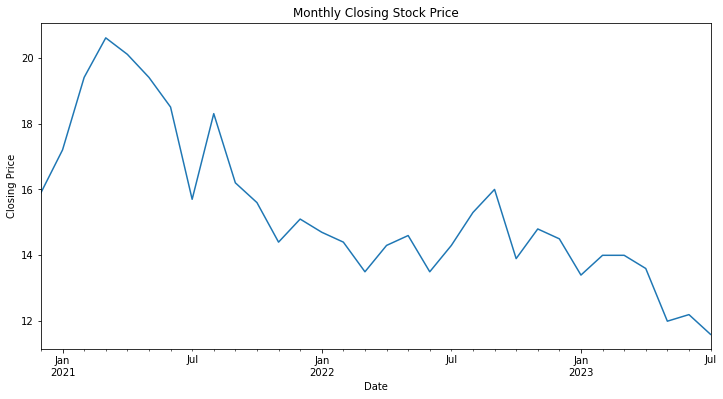

In [3]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12,6))

# Plot the data
monthly_data.plot(ax=ax)

# Set the title and labels
ax.set_title('Monthly Closing Stock Price')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')

# Show the plot
plt.show()


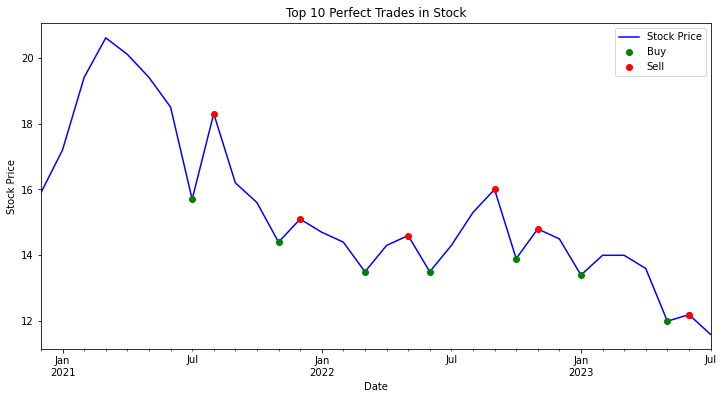

In [4]:
from scipy.signal import argrelextrema

# Convert the series to numpy array for argrelextrema
price_array = monthly_data.values

# Find local minima - points where the price is lower than both the previous and next points
local_minima = argrelextrema(price_array, np.less)

# Find local maxima - points where the price is higher than both the previous and next points
local_maxima = argrelextrema(price_array, np.greater)

# Initialize a list to store the trades
trades = []

# Loop through each local minimum
for min_index in local_minima[0]:
    # Find the next local maximum
    next_maxima = local_maxima[0][local_maxima[0] > min_index]
    if next_maxima.size > 0:
        max_index = next_maxima[0]
        # Add the trade (buy at local minimum, sell at next local maximum)
        trades.append((min_index, max_index))

# Sort the trades by return (sell price - buy price) in descending order
trades.sort(key=lambda x: price_array[x[1]] - price_array[x[0]], reverse=True)

# Select the top 10 trades
top_trades = trades[:10]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12,6))

# Plot the stock price
monthly_data.plot(ax=ax, color='blue', zorder=1)

# Plot the trades
for trade in top_trades:
    # Plot the buy point
# Plot the buy point
    ax.scatter(monthly_data.index[trade[0]], monthly_data.iloc[trade[0]], color='green', zorder=2)
    # Plot the sell point
    ax.scatter(monthly_data.index[trade[1]], monthly_data.iloc[trade[1]], color='red', zorder=2)

# Set the title and labels
ax.set_title('Top 10 Perfect Trades in Stock')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

# Show the legend
ax.legend(["Stock Price", "Buy", "Sell"])

# Show the plot
plt.show()
